In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
from pandas import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf
from statsmodels.tsa.statespace import sarimax
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
energy_cons = pd.read_csv('./household_power_consumption.txt', sep=';', 
                          parse_dates={'Date_time': ['Date', 'Time']}, infer_datetime_format=True, 
                          na_values=['?'], index_col='Date_time').resample('D').mean()

## Deep learning and LSTM
Deep learning is a group of machine learning typically characterized by application of multi-layer ANN architectures together with efficient use of back propagation and stochastic gradient descent.

Different network architectures can be used, depending on the application. CNNs (Convolution Neural Netoworks) are often used in computer vision. RNNs (Recurrent Neural Networks) are often used for language modeling. LSTM (Long short-therm memory) networks are a type of RNNs often used for time series prediction or hand writing recognition. Other architectures exist.

LSTM are capable of learning patterns farther apart in time than for other types of RNNs.

## Data preparation
As in ARIMA example we will use 1 year of data for training and 1 year for testing. Deep nets can be sesitive to data scaling, therefore, we beging by scaling the data.

Since at this point we have not split the data into training and testing sets, we can use one scaler. It is important not to modify the scaler object because it is necessary to bring data back in their original scale at the end.

In [10]:
tt_scaler = MinMaxScaler()
tt_data = energy_cons['Global_active_power']['2008-07-01':'2010-06-30'].fillna(method='bfill')
tt_data = tt_data.values.reshape(tt_data.shape[0],1)
tt_data = tt_scaler.fit_transform(tt_data)

The approach we take is to feed last seven days of energy consumption at a time and predict the consumption for the subsequent day. Based on LSTM architecture the network should discover any longe term patterns on its own.

We use the *roll* function in NumPy to time shift time series multiple times, we then merge the results in one array using *hstack*. Finally, data is divided into training and test sets.

In [11]:
X = np.hstack((tt_data, np.roll(tt_data, -1), 
           np.roll(tt_data, -2), np.roll(tt_data, -3),
           np.roll(tt_data, -4), np.roll(tt_data, -5),
           np.roll(tt_data, -6)))[:-8]
y = np.roll(tt_data,-7)[:-8]

X_train,X_test = X[:361],X[361:]
y_train,y_test = y[:361],y[361:]

## Creating the LSTM model 
We create our model by combining 2 LSTM networks and then Dropout and Dense. For the first LSTM layer we need to specify *input shape*. In our case it is a value for one feature over 7 timestamps.

We apply second LSTM layer with a hope that it will help in learning higher level patterns in the time series. Choosing the right layers and parameters is a topic on beyond this tutorial.

Dropout is a regularization technique that randomly ignores a certain percentage of neurons, what should help with overfitting.

Dense is a fully-connected NN layer that is used to reduce dimentionality of output.

In [220]:
model = Sequential([
    LSTM(16, input_shape=(7,1), return_sequences=True),
    LSTM(4),
    Dropout(.2),
    Dense(1)])
model.compile(optimizer='adam',loss='mean_squared_error')

The model expects a 3 dimensional array with size defined by batch size, number of time steps, number of features.

Our arrays are 2 dimentional, since we only have one feature. We reshape the arrays and fit the model.

*Epoch* parameter defines the number of training steps. Usually higher number will provide a better fit. It might also lead to overfitting, especially with a higher number of neurons.

Specifing *verbose* as zero prevents Keras from displaying training progress. For large models it might better to observe the progress, but it is rather incovienent in a notebook.

In [ ]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
history = model.fit(X_train,y_train,epochs=1000, verbose=0)

## Prediction and evaluation
After the model is trained we use it for prediction with the test set.

We then rescale back the obtained results. We plot and evaluate them in the same way as for the ARIMA model.

0.08827184259708369

0.36736586771799234

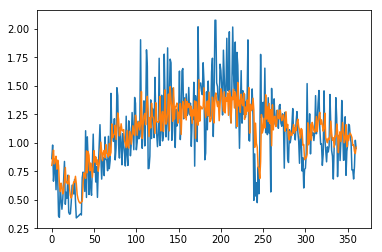

In [221]:
Xt = model.predict(X_test)

plt.plot(tt_scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(tt_scaler.inverse_transform(Xt))
mean_absolute_error(y_test, Xt)
tt_scaler.inverse_transform([[mean_absolute_error(y_test, Xt)]])[0][0]

The scaled error is in fact higher than in case of SARIMAX, but:
- if we predicted on scaled data error goes down to ca. .19, but we don't do it as in general it tends to give worse results
- we did not use trend information (or any other exogonous variables) to support our prediction, if we observe trend for test data we see how much support it actuall provides